importing Jupyter notebook from radio_environment.ipynb
Generate radio environment......


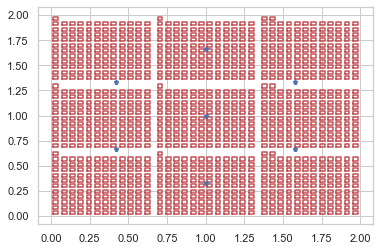

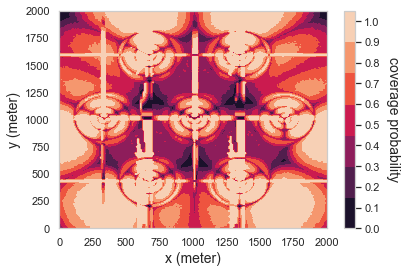

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 19 11:20:58 2019
#Radio mapping based on the measured empirical outage probabilities of the visited locations by UAV
#Based on the measured data, train a DNN for radio mapping:
#Inpt: location, output： outage probability at the location 
@author: Yong Zeng
"""
%matplotlib inline
import numpy as np
#from keras.callbacks import TensorBoard
#import tensorflow as tf
#from collections import deque
#import time
import random
from keras.layers import Input, Dense
from keras.models import Model
#from tqdm import tqdm
#import os
#from sklearn.utils import shuffle
#import scipy.io as spio
#import matplotlib.pyplot as plt
#from numpy import linalg as LA
import import_ipynb
import radio_environment as rad_env


class RadioMap:
    def __init__(self,X_MAX_VAL=2000.0,Y_MAX_VAL=2000.0):
        # Main model
        self.LOC_DIM=2 #2D or 3D trajectory
        self.MINIBATCH_SIZE = 64
        self.X_MAX=X_MAX_VAL
        self.Y_MAX=Y_MAX_VAL#the area region in meters
        self.measured_database=np.zeros(shape=(0,self.LOC_DIM+1), dtype=np.float32)
#UAV가 방문한 모든 지점에 대해 outage 확률을 저장하는 데이터베이스
#각 행 : 한 위치에서 측정한 데이터
#마지막 요소 : Outage 확률
#처음 2요소 -> 2D 위치, 3요소 -> 3D 위치 제공
#the first 2 or 3 elements give the 2D/3D location 
        self.OUTPUT_ACT='softmax'
#        self.OUTPUT_ACT='sigmoid'
        self.map_model = self.create_map_model()      
#        self.initilize_map_model()

    #본 논문에서 소개한 것처럼 map을 만드는 모델과 agent를 학습시키는 모델이 같다.
    def create_map_model(self):
        inp = Input(shape=(self.LOC_DIM,))
        outp=Dense(512,activation='relu')(inp)
        outp=Dense(256,activation='relu')(outp)
        outp=Dense(128,activation='relu')(outp)
        outp=Dense(64,activation='relu')(outp)
        outp=Dense(32,activation='relu')(outp)
        if self.OUTPUT_ACT=='sigmoid':
            outp=Dense(1,activation='sigmoid')(outp)
        else:
            outp=Dense(2,activation='softmax')(outp)
                
            
        model=Model(inp,outp)
        
        if self.OUTPUT_ACT=='sigmoid':
            model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        else:#with softmax output
            model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
            
        model.summary()
        return model
    
    def add_new_measured_data(self,new_row):
        self.measured_database=np.concatenate((self.measured_database,new_row),axis=0)
        #concatenate : axis = 0 -> 열기준으로 배열을 합쳐라\(즉, 열은 그대로 행이 늘어남)
    
    def generate_random_locations(self,num_loc):
        loc_x=np.random.uniform(50,self.X_MAX-50,(num_loc,1))
        loc_y=np.random.uniform(50,self.Y_MAX-50,(num_loc,1))
        loc=np.concatenate((loc_x,loc_y),axis=1)
        return loc
        
    
    def normalize_location(self,location):#normalize the location coordinate to the range betwee 0 and 1 
        MAX_VALS=np.array([[self.X_MAX,self.Y_MAX]])
        return location/MAX_VALS
    
    def predict_outage_prob(self,location):
         pred_array=self.map_model.predict(self.normalize_location(location))
         return pred_array[:,0]
        
    def update_radio_map(self,verbose_on=0):
        if self.measured_database.shape[0]<np.maximum(100,self.MINIBATCH_SIZE): 
            #measured_database의 행(row)<np.maximum(100,self.MINIBATCH_SIZE)
            #np.maximum : 두 array에 대해 동일한 위치의 성분끼리 비교하여 최대값 또는 최소값 계산하기
            #즉, 일정 수 이상 data가 쌓여야 map을 업데이트하겠다!
            return
        
        sampled_idx=random.sample(range(self.measured_database.shape[0]),self.MINIBATCH_SIZE)
        #range(self.measured_database.shape[0]) 중에서 MINIBATCH_SIZE만큼 뽑겠다. 즉, database의 인덱스를 뽑은 것
        train_data=self.measured_database[sampled_idx,:self.LOC_DIM]
        #왜냐하면 마지막 요소는 outage probability니까
        train_label=self.measured_database[sampled_idx,-1]
        #즉, outage probability를 의미
        train_label=train_label.reshape((-1,1))
        #열=1, 모두 행으로 나열하겠다.
        
        if self.OUTPUT_ACT=='softmax':
            train_label=np.concatenate((train_label,1.0-train_label),axis=1)
            
            
        self.map_model.fit(self.normalize_location(train_data),train_label,verbose=verbose_on)
        

        
        
    def check_radio_map_acc(self):
        pred_outage=self.predict_outage_prob(rad_env.TEST_LOC_meter)

        diff_abs=np.abs(rad_env.TEST_LOC_ACTUAL_OUTAGE-pred_outage)
        
        MSE=np.sum(np.square(diff_abs))/len(rad_env.TEST_LOC_ACTUAL_OUTAGE)
        
        MAE=np.sum(diff_abs)/len(rad_env.TEST_LOC_ACTUAL_OUTAGE)
        
        Max_Absolute_Error=np.max(diff_abs)
        
        bin_cross_entr=self.binary_cross_entropy(rad_env.TEST_LOC_ACTUAL_OUTAGE,pred_outage)
        
        return MSE,MAE,Max_Absolute_Error,bin_cross_entr
        
  
    def binary_cross_entropy(self,p_true,p_pred):
        N=len(p_true)
        return -1/N*np.sum(p_true*np.log(p_pred)+(1-p_true)*np.log(1-p_pred))
    
   



In [45]:
import numpy as np
a = np.ones(shape = (5,3))
a.reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [12]:
a.shape[0] < np.maximum(4,3)

False

In [42]:
import random
random.sample(range(10),10)

[5, 3, 0, 4, 1, 6, 8, 2, 7, 9]

In [41]:
range(10)

range(0, 10)